In [1]:
from pytorchcv.model_provider import get_model as ptcv_get_model
import torch
import torch.nn.utils.prune as prune
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
net = ptcv_get_model("resnet20_cifar100", pretrained=True)
net = net.to(device)

In [2]:
import torchvision
import torchvision.transforms as transforms
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.CIFAR100(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=20,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR100(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=4,
                                         shuffle=False, num_workers=2)

classes = ("beaver", "dolphin", "otter", "seal", "whale", "aquarium fish", "flatfish", "ray", "shark", "trout", "orchids", \
           "poppies", "roses", "sunflowers", "tulips", "bottles", "bowls", "cans", "cups", "plates", "apples", "mushrooms", \
           "oranges", "pears", "sweet peppers", "clock", "computer keyboard", "lamp", "telephone", "television", "bed", \
           "chair", "couch", "table", "wardrobe", "bee", "beetle", "butterfly", "caterpillar", "cockroach", "bear", "leopard", \
           "lion", "tiger", "wolf", "bridge", "castle", "house", "road", "skyscraper", "cloud", "forest", "mountain", "plain", "sea", \
           "camel", "cattle", "chimpanzee", "elephant", "kangaroo", "fox", "porcupine", "possum", "raccoon", "skunk", "crab", \
           "lobster", "snail", "spider", "worm", "baby", "boy", "girl", "man", "woman", "crocodile", "dinosaur", "lizard", "snake",\
           "turtle", "hamster", "mouse", "rabbit", "shrew", "squirrel", "maple", "oak", "palm", "pine", "willow", "bicycle", "bus",\
           "motorcycle", "pickup truck", "train", "lawn-mower", "rocket", "streetcar", "tank", "tractor")

Files already downloaded and verified
Files already downloaded and verified


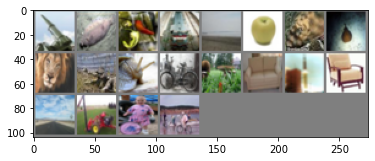

 worm couch shrew bicycle


In [3]:
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image


def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(4)))

In [4]:
parameters_to_prune = (
    (net.features.init_block.conv, "weight"),
    (net.features.stage1.unit1.body.conv1.conv, "weight"),
    (net.features.stage1.unit1.body.conv2.conv, "weight"),
    (net.features.stage1.unit2.body.conv1.conv, "weight"),
    (net.features.stage1.unit2.body.conv2.conv, "weight"),
    (net.features.stage1.unit3.body.conv1.conv, "weight"),
    (net.features.stage1.unit3.body.conv2.conv, "weight"),
    (net.features.stage2.unit1.body.conv1.conv, "weight"),
    (net.features.stage2.unit1.body.conv2.conv, "weight"),
    (net.features.stage2.unit1.identity_conv.conv, "weight"),
    (net.features.stage2.unit2.body.conv1.conv, "weight"),
    (net.features.stage2.unit2.body.conv2.conv, "weight"),
    (net.features.stage2.unit3.body.conv1.conv, "weight"),
    (net.features.stage2.unit3.body.conv2.conv, "weight"),
    (net.features.stage3.unit1.body.conv1.conv, "weight"),
    (net.features.stage3.unit1.body.conv2.conv, "weight"),
    (net.features.stage3.unit1.identity_conv.conv, "weight"),
    (net.features.stage3.unit2.body.conv1.conv, "weight"),
    (net.features.stage3.unit2.body.conv2.conv, "weight"),
    (net.features.stage3.unit3.body.conv1.conv, "weight"),
    (net.features.stage3.unit3.body.conv2.conv, "weight"),
    (net.output, "weight")
)


In [5]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.8, weight_decay=1e-4)

In [6]:
def test():
    correct = 0
    total = 0
    with torch.no_grad():
        for i, data in enumerate(testloader, 0):
            if i > 25:
                break
            images, labels = data[0].to(device), data[1].to(device)
            outputs = net(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    print('Accuracy of the network on 100 test images: %d %%' % (
        100 * correct / total))

In [7]:
n_prune = 10
for p in range(n_prune):
    test()
    print("prune")
    prune.global_unstructured(
                parameters_to_prune,
                pruning_method=prune.L1Unstructured,
                amount=0.2,
            )
    test()
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data[0].to(device), data[1].to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        if i % 500 == 0:
            test()

Accuracy of the network on 100 test images: 55 %
prune
Accuracy of the network on 100 test images: 56 %
Accuracy of the network on 100 test images: 56 %
Accuracy of the network on 100 test images: 53 %
Accuracy of the network on 100 test images: 50 %
Accuracy of the network on 100 test images: 52 %
Accuracy of the network on 100 test images: 51 %
Accuracy of the network on 100 test images: 53 %
prune
Accuracy of the network on 100 test images: 49 %
Accuracy of the network on 100 test images: 49 %
Accuracy of the network on 100 test images: 51 %
Accuracy of the network on 100 test images: 51 %
Accuracy of the network on 100 test images: 56 %
Accuracy of the network on 100 test images: 52 %
Accuracy of the network on 100 test images: 52 %
prune
Accuracy of the network on 100 test images: 50 %
Accuracy of the network on 100 test images: 50 %
Accuracy of the network on 100 test images: 56 %
Accuracy of the network on 100 test images: 52 %
Accuracy of the network on 100 test images: 55 %
Ac

In [10]:
optimizer = optim.SGD(net.parameters(), lr=0.0005)
n_epoch = 5
for p in range(n_epoch):
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data[0].to(device), data[1].to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        if i % 500 == 0:
            test()

Accuracy of the network on 100 test images: 39 %
Accuracy of the network on 100 test images: 39 %
Accuracy of the network on 100 test images: 40 %
Accuracy of the network on 100 test images: 38 %
Accuracy of the network on 100 test images: 38 %
Accuracy of the network on 100 test images: 38 %
Accuracy of the network on 100 test images: 38 %
Accuracy of the network on 100 test images: 39 %
Accuracy of the network on 100 test images: 39 %
Accuracy of the network on 100 test images: 38 %
Accuracy of the network on 100 test images: 37 %
Accuracy of the network on 100 test images: 38 %
Accuracy of the network on 100 test images: 36 %
Accuracy of the network on 100 test images: 37 %
Accuracy of the network on 100 test images: 38 %


KeyboardInterrupt: 

In [12]:
if True: 
    correct = 0
    total = 0
    with torch.no_grad():
        for i, data in enumerate(testloader, 0):
            images, labels = data[0].to(device), data[1].to(device)
            outputs = net(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    print('Accuracy of the network on 10000 test images: %d %%' % (
        100 * correct / total))

Accuracy of the network on 10000 test images: 39 %


In [14]:
for (p, _) in parameters_to_prune:
    print(torch.sum(p.weight_mask).item(), " / ", torch.sum(1*p.weight_mask >= 0).item())

262.0  /  432
568.0  /  2304
524.0  /  2304
493.0  /  2304
479.0  /  2304
673.0  /  2304
426.0  /  2304
1036.0  /  4608
1407.0  /  9216
196.0  /  512
1203.0  /  9216
799.0  /  9216
1317.0  /  9216
711.0  /  9216
1905.0  /  18432
3099.0  /  36864
420.0  /  2048
2891.0  /  36864
2430.0  /  36864
3412.0  /  36864
1497.0  /  36864
3957.0  /  6400
